# Data Exploration

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [2]:
data = pd.read_csv('data.csv', decimal=',')
data['Sedentary_hours_daily'] = data['Sedentary_hours_daily'].astype(float)
data['Regular_fiber_diet'] = data['Regular_fiber_diet'].astype(float)
data['Age'] = data['Age'].astype(float)
data['Est_avg_calorie_intake'] = data['Est_avg_calorie_intake'].astype(int)
data['Main_meals_daily'] = data['Main_meals_daily'].astype(int)
data['Height'] = data['Height'].astype(float)
data['Water_daily'] = data['Water_daily'].astype(int)
data['Weight'] = data['Weight'].astype(float)
data['Physical_activity_level'] = data['Physical_activity_level'].astype(int)
data['Technology_time_use'] = data['Technology_time_use'].astype(int)
numeric_attributes = data[['Sedentary_hours_daily', 'Regular_fiber_diet', 'Age', 'Est_avg_calorie_intake', 'Main_meals_daily',\
                      'Height', 'Water_daily', 'Weight', 'Physical_activity_level', 'Technology_time_use']]
categorical_attributes = data[['Transportation', 'Diagnostic_in_family_history',\
                          'High_calorie_diet', 'Alcohol', 'Snacks', 'Smoker', 'Calorie_monitoring', 'Gender']]

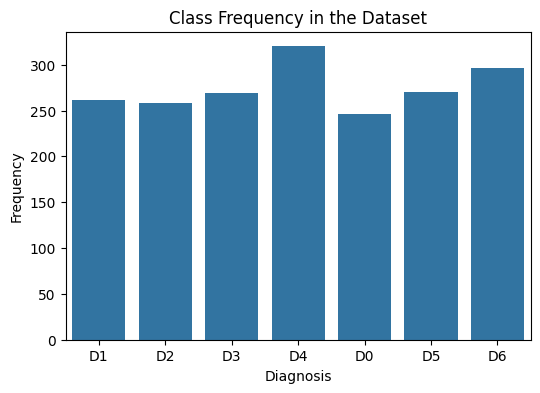

In [3]:
# Class equilibrium
plt.figure(figsize=(6, 4))
sns.countplot(x='Diagnostic', data=data)
plt.title('Class Frequency in the Dataset')
plt.xlabel('Diagnosis')
plt.ylabel('Frequency')
plt.show()

Statistics for column Sedentary_hours_daily
Mean: 3.693571056741281
Std Deviation: 21.759834908880748
Mean Abs Deviation: 1.1338850443643116
Min Val: 2.21
Max Val: 956.58
Amplitude: 954.37
Median: 3.13
Median Abs Deviation: 0.43999999999999995
Interquantil Interval: 0.8700000000000001

Statistics for column Regular_fiber_diet
Mean: 3.8449373862571576
Std Deviation: 62.4396174995684
Mean Abs Deviation: 2.8476367127680824
Min Val: 1.0
Max Val: 2739.0
Amplitude: 2738.0
Median: 2.387426
Median Abs Deviation: 0.38742600000000005
Interquantil Interval: 1.0

Statistics for column Age
Mean: 44.79250626392504
Std Deviation: 633.3118370767136
Mean Abs Deviation: 40.94688616864699
Min Val: 15.0
Max Val: 19685.0
Amplitude: 19670.0
Median: 22.829753
Median Abs Deviation: 3.170247
Interquantil Interval: 6.02834

Statistics for column Est_avg_calorie_intake
Mean: 2253.68766267569
Std Deviation: 434.07579419142866
Mean Abs Deviation: 375.36234408538627
Min Val: 1500
Max Val: 3000
Amplitude: 1500
Media

<Figure size 800x600 with 0 Axes>

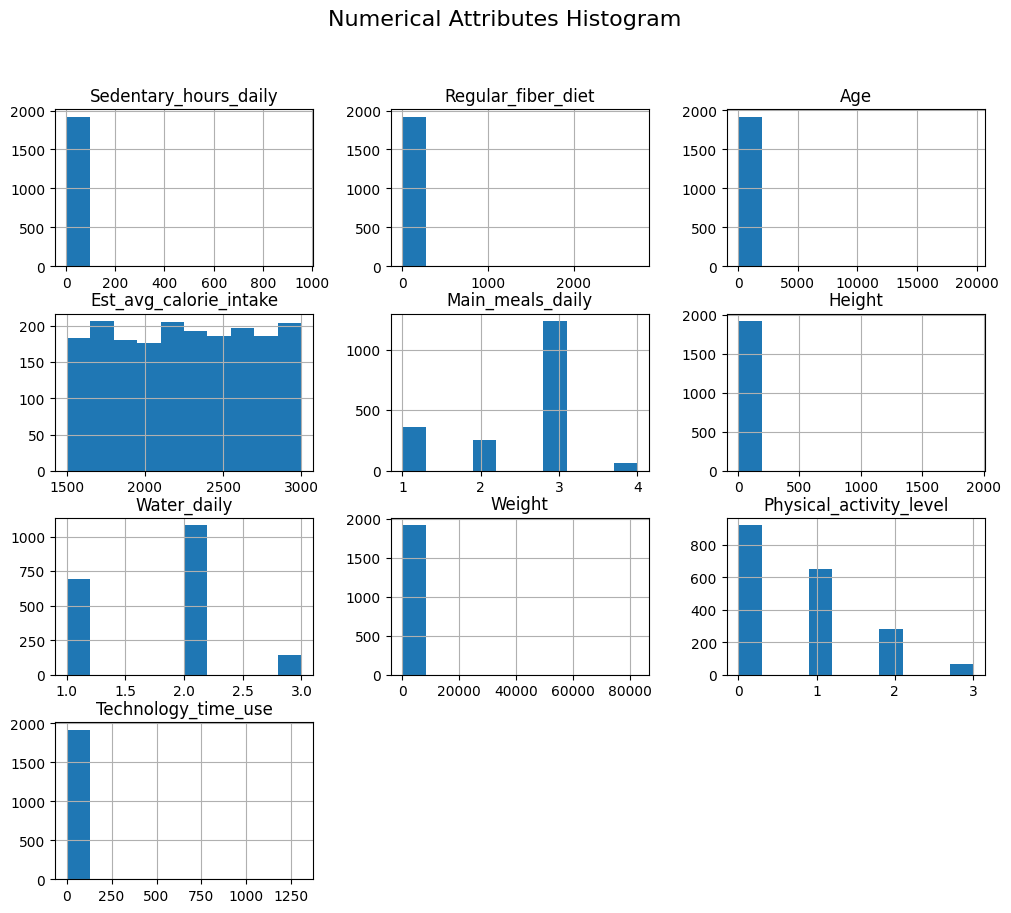

Statistics for column Transportation
Unique values: ['Public_Transportation' 'Walking' 'Automobile' 'Motorbike' 'Bike']

Statistics for column Diagnostic_in_family_history
Unique values: ['yes' 'no']

Statistics for column High_calorie_diet
Unique values: ['no' 'yes']

Statistics for column Alcohol
Unique values: ['no' 'Sometimes' 'Frequently' 'Always']

Statistics for column Snacks
Unique values: ['Sometimes' 'Frequently' 'Always' 'no']

Statistics for column Smoker
Unique values: ['no' 'yes']

Statistics for column Calorie_monitoring
Unique values: ['no' 'yes']

Statistics for column Gender
Unique values: ['Female' 'Male']



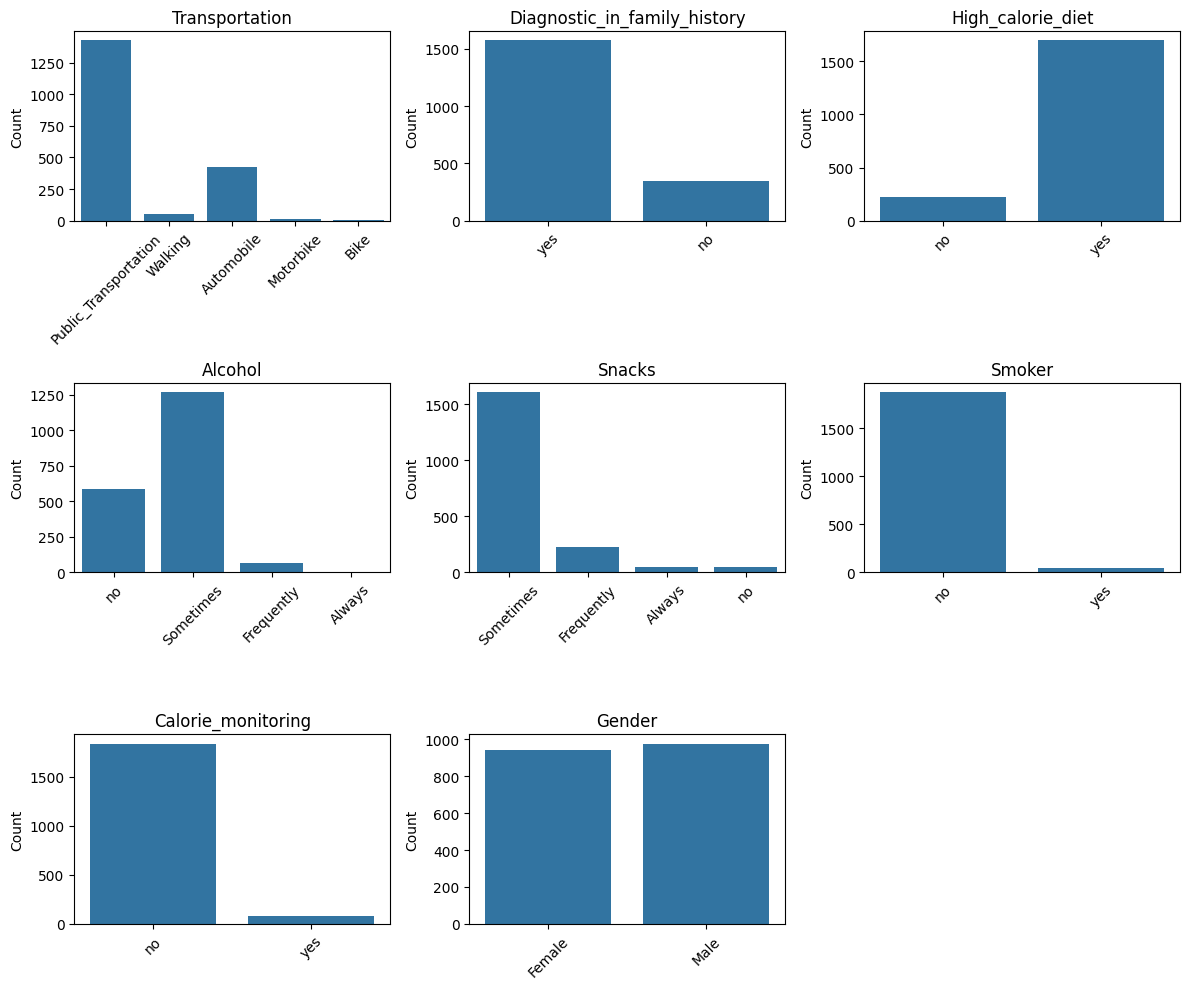

In [4]:
# Numerical Attributes
mad = lambda x: np.mean(np.abs(x - np.mean(x)))
mead = lambda x: np.median(np.abs(x - np.median(x)))

for column in numeric_attributes.columns:
    print("Statistics for column", column)
    print("Mean:", numeric_attributes[column].mean())
    print("Std Deviation:", numeric_attributes[column].std())
    print("Mean Abs Deviation:", mad(numeric_attributes[column]))
    print("Min Val:", numeric_attributes[column].min())
    print("Max Val:", numeric_attributes[column].max())
    print("Amplitude:", numeric_attributes[column].max() - numeric_attributes[column].min())
    print("Median:", numeric_attributes[column].median())
    print("Median Abs Deviation:", mead(numeric_attributes[column]))
    q1 = numeric_attributes[column].quantile(0.25)
    q3 = numeric_attributes[column].quantile(0.75)
    print("Interquantil Interval:", q3 - q1)
    print()

plt.figure(figsize=(8, 6))
numeric_attributes.hist(figsize=(12, 10))
plt.suptitle('Numerical Attributes Histogram', fontsize=16)
plt.show()

for column in categorical_attributes.columns:
    print("Statistics for column", column)
    print("Unique values:", categorical_attributes[column].unique())
    print()

plt.figure(figsize=(12, 10))
for i, column in enumerate(categorical_attributes.columns, 1):
    plt.subplot(3, 3, i)
    sns.countplot(x=column, data=data)
    for tick in plt.gca().get_xticklabels():
        tick.set_rotation(45)
    plt.title(column)
    plt.xlabel("")
    plt.ylabel("Count")

plt.tight_layout()
plt.show()

In [5]:
from sklearn.preprocessing import LabelEncoder

# encode categorical attributes
encoder = LabelEncoder()
for column in categorical_attributes.columns:
    data[column] = encoder.fit_transform(data[column])
data['Diagnostic'] = encoder.fit_transform(data['Diagnostic'])

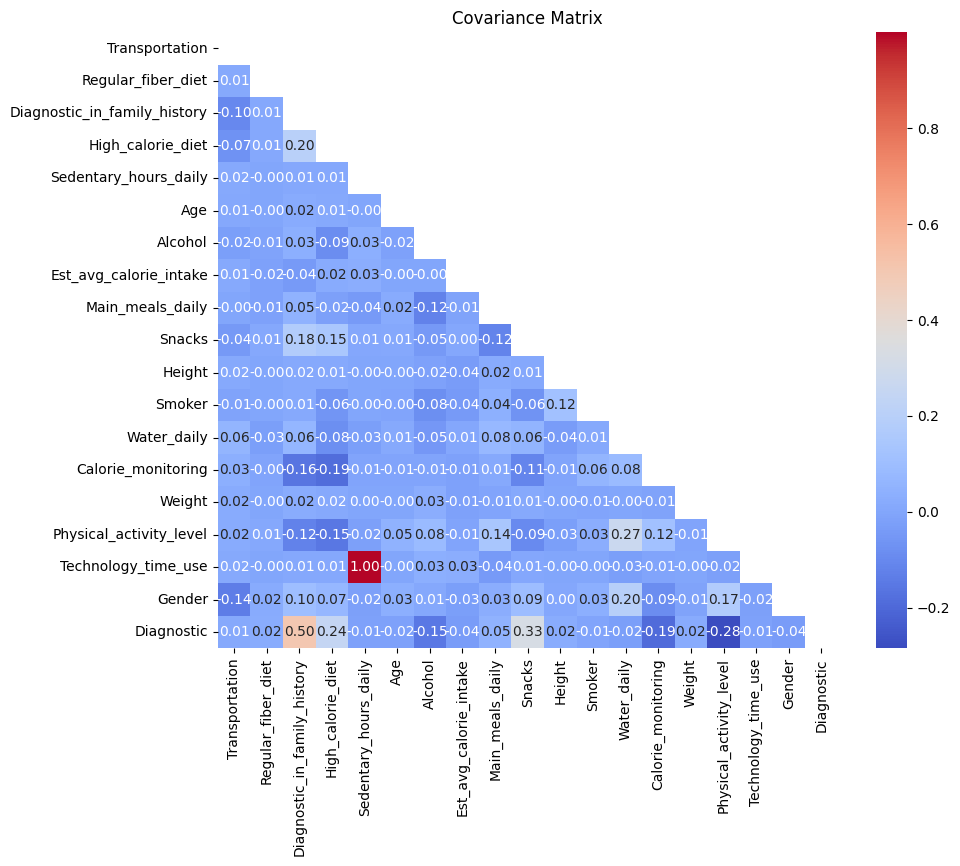

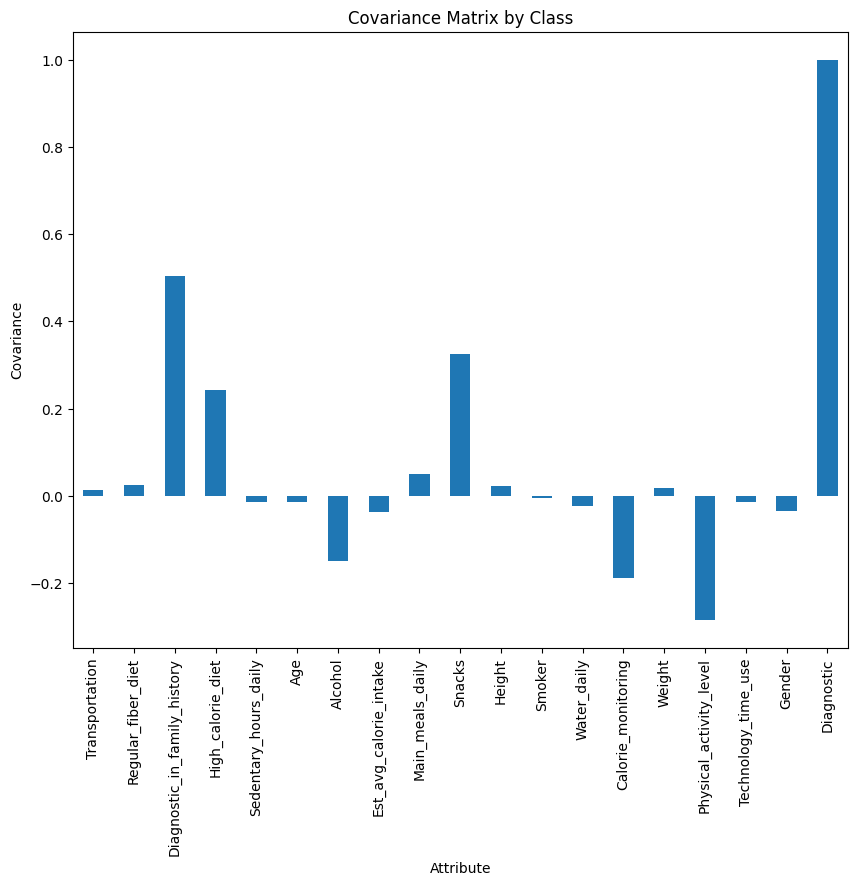

In [6]:
# Covariance Matrix
covariance_matrix = data.corr()
mask = np.triu(np.ones_like(covariance_matrix, dtype=bool))
covariance_matrix = covariance_matrix.mask(mask)
plt.figure(figsize=(10, 8))
sns.heatmap(covariance_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Covariance Matrix')
plt.show()

class_cov = data.corrwith(data['Diagnostic'])
plt.figure(figsize=(10, 8))
class_cov.plot(kind='bar')
plt.title('Covariance Matrix by Class')
plt.xlabel('Attribute')
plt.ylabel('Covariance')
plt.show()

# Learning

In [7]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
import xgboost as xgb
from sklearn.svm import SVC
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.feature_selection import SelectPercentile
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from scipy.stats import zscore

In [8]:
# remove outliers
z_scores = numeric_attributes.apply(zscore)
numeric_attributes[z_scores.abs() > 3] = np.nan

/tmp/ipykernel_68703/2280890417.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  numeric_attributes[z_scores.abs() > 3] = np.nan
/tmp/ipykernel_68703/2280890417.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  numeric_attributes[z_scores.abs() > 3] = np.nan


In [9]:
# treat missing values
imputer = IterativeImputer(missing_values=-1, max_iter=10)
data['Weight'] = imputer.fit_transform(data[['Weight']])
for column in numeric_attributes:
    data[column] = imputer.fit_transform(data[[column]])

In [10]:
# feature selection

print("Initial features:")
print(data.columns)
selector = SelectPercentile(percentile=80)
selector.fit(data.drop(columns=['Diagnostic']), data['Diagnostic'])
selected_indices = selector.get_support(indices=True)
X_selected = data.iloc[:, selected_indices]
print("Features after selection:")
selector.get_feature_names_out()

Initial features:
Index(['Transportation', 'Regular_fiber_diet', 'Diagnostic_in_family_history',
       'High_calorie_diet', 'Sedentary_hours_daily', 'Age', 'Alcohol',
       'Est_avg_calorie_intake', 'Main_meals_daily', 'Snacks', 'Height',
       'Smoker', 'Water_daily', 'Calorie_monitoring', 'Weight',
       'Physical_activity_level', 'Technology_time_use', 'Gender',
       'Diagnostic'],
      dtype='object')
Features after selection:


array(['Transportation', 'Diagnostic_in_family_history',
       'High_calorie_diet', 'Age', 'Alcohol', 'Est_avg_calorie_intake',
       'Main_meals_daily', 'Snacks', 'Smoker', 'Water_daily',
       'Calorie_monitoring', 'Weight', 'Physical_activity_level',
       'Gender'], dtype=object)

In [11]:
# standardize data
scaler = StandardScaler()
data[numeric_attributes.columns] = scaler.fit_transform(data[numeric_attributes.columns])

In [12]:
X_train, X_test, Y_train, Y_test = train_test_split(X_selected, data['Diagnostic'], test_size=0.2, random_state=42)

In [13]:
# hyperparameters

param_grid_rf = {'n_estimators': [100, 200, 300],
                 'max_depth': [None, 10, 20],
                 'max_features': ['sqrt', 'log2']}
param_grid_et = {'n_estimators': [100, 200, 300],
                 'max_depth': [None, 10, 20],
                 'max_features': ['sqrt', 'log2']}
param_grid_gb = {'n_estimators': [100, 200, 300],
                 'max_depth': [3, 5, 7],
                 'learning_rate': [0.1, 0.05, 0.01]}
param_grid_svm = {'kernel': ['linear', 'poly', 'rbf'],
                  'C': [0.1, 1, 10]}

In [14]:
models = [RandomForestClassifier(), ExtraTreesClassifier(), xgb.XGBClassifier(), SVC()]

grid_search_results = {}

for model in models:
    if isinstance(model, RandomForestClassifier):
        new_model = GridSearchCV(model, param_grid_rf, cv=5)
    elif isinstance(model, ExtraTreesClassifier):
        new_model = GridSearchCV(model, param_grid_et, cv=5)
    elif isinstance(model, xgb.XGBClassifier):
        new_model = GridSearchCV(model, param_grid_gb, cv=5)
    elif isinstance(model, SVC):
        new_model = GridSearchCV(model, param_grid_svm, cv=5)
    new_model.fit(X_train, Y_train)
    grid_search_results[model.__class__.__name__] = new_model


Evaluation for RandomForestClassifier:
Hyper-parameter configuration:
{'max_depth': 20, 'max_features': 'log2', 'n_estimators': 200}
Mean and variance:
Accuracy: 0.8363636363636363
Precision: [0.92307692 0.67241379 0.6744186  0.75       0.87692308 0.92063492
 1.        ]
Recall: [0.8        0.75       0.69047619 0.79591837 0.82608696 0.96666667
 0.98113208]
F1: [0.85714286 0.70909091 0.68235294 0.77227723 0.85074627 0.94308943
 0.99047619]

Evaluation for ExtraTreesClassifier:
Hyper-parameter configuration:
{'max_depth': None, 'max_features': 'log2', 'n_estimators': 200}
Mean and variance:
Accuracy: 0.8
Precision: [0.85454545 0.62962963 0.74358974 0.68518519 0.77941176 0.88888889
 1.        ]
Recall: [0.78333333 0.65384615 0.69047619 0.75510204 0.76811594 0.93333333
 0.98113208]
F1: [0.8173913  0.64150943 0.71604938 0.7184466  0.77372263 0.91056911
 0.99047619]

Evaluation for XGBClassifier:
Hyper-parameter configuration:
{'learning_rate': 0.05, 'max_depth': 7, 'n_estimators': 300}
Me

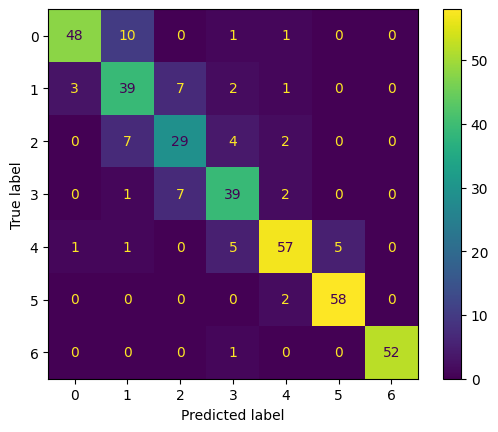

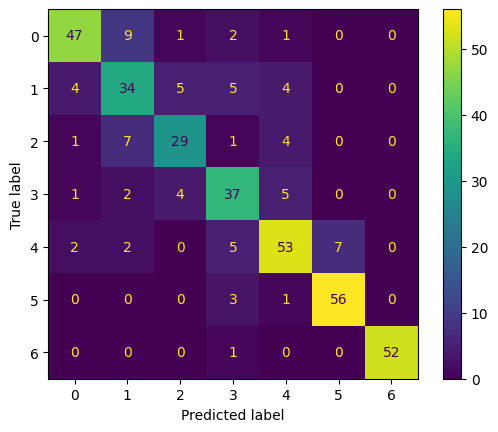

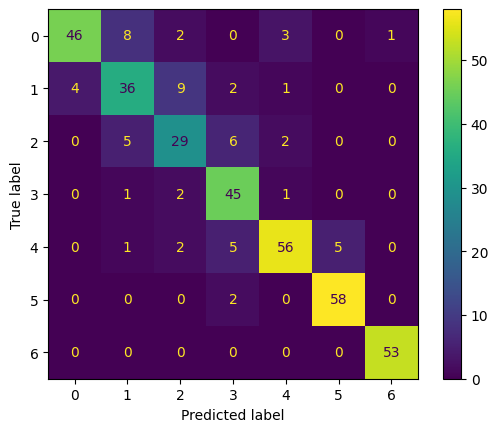

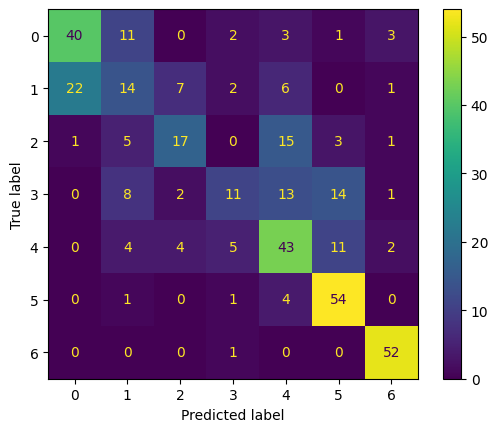

In [15]:
for model_name, grid_search in grid_search_results.items():
    print(f"\nEvaluation for {model_name}:")
    print("Hyper-parameter configuration:")
    print(grid_search.best_params_)
    print("Mean and variance:")

    y_pred = grid_search.predict(X_test)

    accuracy = accuracy_score(Y_test, y_pred)
    precision = precision_score(Y_test, y_pred, average=None)
    recall = recall_score(Y_test, y_pred, average=None)
    f1 = f1_score(Y_test, y_pred, average=None)

    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1:", f1)

    # Confusion matrix for the best model
    best_model = grid_search.best_estimator_
    y_pred_best = best_model.predict(X_test)
    cm = confusion_matrix(Y_test, y_pred_best)
    ConfusionMatrixDisplay(cm).plot()